In [1]:
import numpy as np
from scipy.special import binom

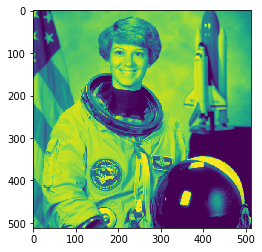

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
image = fits.getdata('eileencollins.fits') + 1.
plt.imshow(image)
plt.show()

In [3]:
def zernike_radial(r, n, m):
    """calculates radial component of a Zernike polynomial
    
    Arguments:
    r    :    normalized radial coordinates, np.ndarray
    n    :    Radial frequency n, integer int
    m    :    Azimuthal frequency m, m<=n, integer int
    
    Returns:
    R    :    radial component of the Zernike n, m"""
    
    R = np.zeros_like(r)
    
    for k in range((n-m)//2 + 1):
        cofactor_1 = int(np.round(binom(n-k,k)))
        cofactor_2 = int(np.round(binom(n-2*k, (n-m) // 2 - k)))
        R += (-1)**k * cofactor_1 * cofactor_2 * r**(n-2*k)
    return R

def zernike_azimuthal(m, theta):
    """calculates azimuthal component of a Zernike polynomial
    
    Arguments:
    m    :    Azimuthal frequency m, m<=n, integer int
    theta:    azimuthal coordinate coordinates, np.ndarray

    Returns:
    azi  :    azimuthal component of the Zernike n, m"""
    
    if m < 0:
        return np.sqrt(2) * np.sin(m * theta)
    elif m == 0:
        return 1
    else:
        return np.sqrt(2) * np.cos(m * theta)
    
def zernike(n, m, coords, polar=False, D=2, disk=True):
    """calculates the Zernike polynomial
    
    Argument:
    n    :    Radial frequency n, int
    m    :    Azimuthal frequency m, m<=n, int
    coords:   coordinates to evaluate Zernikes, np.ndarray
    polar:    True if coords is already in polar coordinates
    D    :    diameter of Zernike polynomial, (int, float) 
    disk :    True to evaluate on unit disk, False for 2r/d>1
    
    Returns:
    Z    :    Zernike polynomial for n, m
    """
    
    if polar:
        R, theta = coords
    else:
        R = (coords[0]**2 + coords[1]**2)**.5
        theta = np.arctan2(coords[1], coords[0])
    
    Z_r = zernike_radial(2*R/D, n, abs(m))
    if disk:
        Z_r *= 2*R <= D
    Z_phi = zernike_azimuthal(m, theta)
    Z = np.sqrt(n + 1)* Z_phi * Z_r
    
    return Z
        

In [7]:
def ansi_to_zernike(j):
    n = int((np.sqrt(8 * j + 1) - 1) / 2)
    m = 2 * j - n * (n + 2)
    return (n, m)

In [11]:
def zernike_reconstruct(img, radius, j_max, center, save_coeffs=False):
    """reconstructs an image using Zernike moments
    
    Arguments:
    img   :    image to reconstruct
    radius:    radius of disk to fit with Zernikes, in pixel units
    j_max :    maximum ansi index (number of modes for reconstruction)
    center:    center of disk to fit with Zernikes, in pixel coordinates
    
    Returns:
    a     :    Reconstruction of img with n_max charges"""
    
    shape = img.shape
    Y, X = np.mgrid[:shape[0], :shape[1]] # get coordinates
    Yc = ((Y - center[0]) / radius) # normalize coordinates
    Xc = ((X - center[1]) / radius)
    
    R = (Yc ** 2 + Xc ** 2)**.5
    theta = np.arctan2(Yc, Xc)
    npix = np.sum(R <= 1)
    
    reconstruction = np.zeros(shape)
    
    coeffs = []
    for j in range(j_max + 1):
        n,m = ansi_to_zernike(j)
        Z = zernike(n, m, (R, theta), polar=True, D=2, disk=True)
        a = np.sum(img * Z) / npix
        reconstruction += a * Z
        coeffs.append(a)

    reconstruction[R>1] = np.nan
    return reconstruction, coeffs

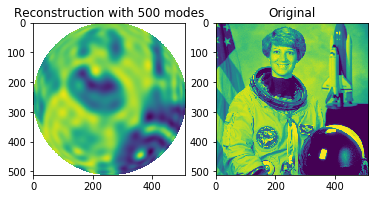

In [174]:
N=500
reconstruction, coeffs= zernike_reconstruct(image, 256, N, (256,256), True)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(reconstruction.reshape(image.shape))
ax1.set_title('Reconstruction with {} modes'.format(N))
ax2.imshow(image)
ax2.set_title('Original')
plt.show()

In [175]:
img = image.copy()
center = (256, 256)
radius = 256
shape = img.shape
Y, X = np.mgrid[:shape[0], :shape[1]] # get coordinates
Yc = ((Y - center[0]) / radius) # normalize coordinates
Xc = ((X - center[1]) / radius)

R = (Yc ** 2 + Xc ** 2)**.5
theta = np.arctan2(Yc, Xc)
npix = np.sum(R <= 1)
out = []
for j in range(N + 1):
    n,m = ansi_to_zernike(j)
    Z = zernike(n, m, (R, theta), polar=True, D=2, disk=True)
    a = np.sum(img * Z) / npix
    img -= a * Z
    W_mean = 1/npix * np.nansum(img)
    W_2_mean = 1/npix * np.nansum(img ** 2)
    out.append(np.sqrt(W_2_mean - W_mean**2))
img[R>1] = np.nan

Text(0, 0.5, 'RMS Wavefront Error (DNs)')

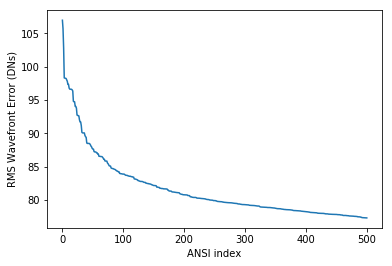

In [178]:
plt.plot(out)
plt.xlabel('ANSI index')
plt.ylabel('RMS Wavefront Error (DNs)')
